In [1]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset,Subset, random_split
from sklearn.model_selection import KFold
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
import torchvision.transforms.functional as F
import torch.nn as nn
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import display
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import torchmetrics, argparse

from torchvision.datasets import ImageFolder

from PIL import Image, ImageOps
import os

import multiprocessing
num_workers = multiprocessing.cpu_count()
print(num_workers)
import timm
import wandb
import segmentation_models_pytorch as smp
from ultralytics import YOLO

/root/signate_tecno/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


32


In [4]:
import os
from PIL import Image

def check_all_images(data_dir):
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                try:
                    image = Image.open(image_path)
                    image.verify()
                except Exception as e:
                    print(f"Invalid image {image_path}: {e}")

check_all_images(CFG.input_dir)

## segmentaionmodel

In [44]:
import glob
npy_files = glob.glob('/root/signate_tecno/input/*/*/*.npy')
for file_path in npy_files:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

Deleted: /root/signate_tecno/input/train/hold/223jbxV6dHyxYyMpAq98o8_mask.npy
Deleted: /root/signate_tecno/input/train/hold/226BprmULorsmUEnsDG9dq_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22BzUYWZUTH2RDsiiPk3BF_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22XsVueVCNLbSRjYm3ZcYr_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22YKfcBojrANnEhnLrKsJz_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22aPWYFyosdL95WHCSX32y_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22g8DXs9xkx3uVntfunmWw_mask.npy
Deleted: /root/signate_tecno/input/train/hold/22wyYtuj593MCX3VUN4dLv_mask.npy
Deleted: /root/signate_tecno/input/train/hold/23B4Kb4XMP5VtRuWCGDyha_mask.npy
Deleted: /root/signate_tecno/input/train/hold/23DT38z6iEWYfaiczEzhLC_mask.npy
Deleted: /root/signate_tecno/input/train/hold/23E7KuBJjuGUdseu7FBJtX_mask.npy
Deleted: /root/signate_tecno/input/train/hold/23MDtHUVbnCJTpiJTEKpbH_mask.npy
Deleted: /root/signate_tecno/input/train/hold/23TiZ8mhCYVvxLbEYa

In [38]:
# モデルのロード（例としてDeepLabV3+を使用）
model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b4',
    encoder_weights='imagenet',
    classes=3,  # クラス数（背景、人物、扇）
    activation=None,
)
model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    
    # 画像のパディング
    width, height = image.size
    new_width = ((width + 31) // 32) * 32  # 幅を16の倍数に
    new_height = ((height + 31) // 32) * 32  # 高さを16の倍数に
    pad_width = new_width - width
    pad_height = new_height - height
    padding = (0, 0, pad_width, pad_height)  # 左, 上, 右, 下
    image = F.pad(image, padding, fill=0)
    
    # 前処理関数の適用
    preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
    image = preprocessing_fn(np.array(image))

    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    return image

def get_segmentation_mask(image):
    with torch.no_grad():
        output = model(image)
    # 出力はクラス数のチャンネルを持つ
    mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return mask  # マスクは0（背景）、1（人物）、2（扇）のラベルを持つ

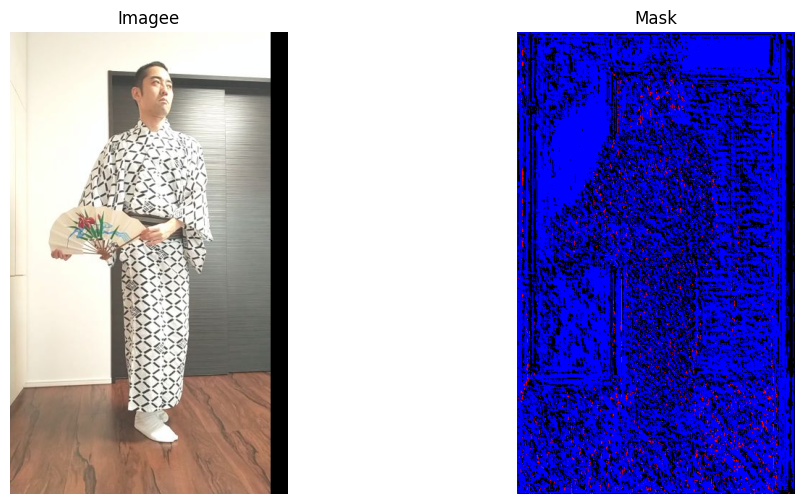

In [39]:
def display_image_and_mask(image, mask):
    import matplotlib.pyplot as plt
    import numpy as np

    # 画像のデノーマライズ
    mean = np.array([0.485, 0.456, 0.406])  # ImageNetの平均値
    std = np.array([0.229, 0.224, 0.225])   # ImageNetの標準偏差

    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    image = std * image + mean  # デノーマライズ
    image = np.clip(image, 0, 1)  # 値を[0,1]の範囲にクリップ

    # マスクの色マップを定義
    mask_color = {
        0: [0, 0, 0],          # 背景（黒）
        1: [0, 0, 255],        # 人物（青）
        2: [255, 0, 0],        # 扇（赤）
    }

    # マスクをカラー画像に変換
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in mask_color.items():
        mask_rgb[mask == label] = color

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 画像を表示
    axes[0].imshow(image)
    axes[0].set_title('Imagee')
    axes[0].axis('off')

    # マスクを表示
    axes[1].imshow(mask_rgb)
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()


# Example usage
image_path = '/root/signate_tecno/input/train/hold/22BzUYWZUTH2RDsiiPk3BF.jpg'
image = preprocess_image(image_path)
mask = get_segmentation_mask(image)
display_image_and_mask(image.squeeze(), mask)

In [20]:
for path in ds.image_paths:
    image = preprocess_image(path)
    mask = get_segmentation_mask(image)
    # マスクを保存（例としてNumPy配列として保存）
    np.save(path.replace('.jpg', '_mask.npy'), mask)

## training

In [8]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hayatarou-ay. Use `wandb login --relogin` to force relogin


True

In [17]:
class CFG:
    ver = 4.1
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_dir =  "/root/signate_tecno/"
    input_dir = base_dir + "input/crop_train"
    test_dir = base_dir + "input/crop_test"
    output_dir = base_dir + "output/"
    sub_dir  = base_dir + "submit/"
    log_dir = base_dir + "logs/"
    model_dir = base_dir + "model/"
    ckpt_dir = base_dir + "ckpt/"

    MODEL = "vit-tiny"
    DATASET = "TECNO"
    n_folds = 5

    learning_rate = 1e-3
    weight_decay = 1e-5
    optimizer = "AdamW"
    data_aug = "RandAug"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## train用のデータセット作成

In [18]:
class ImageDataset(Dataset):
    def __init__(self,data_dir,transform=None,phase = "train"):
        super().__init__()
        self.data = []
        for label_name in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label_name)
            label = 1 if label_name == "hold" else 0
            for image_name in os.listdir(label_dir):
                if image_name.endswith(".jpg"):
                    image_path = os.path.join(label_dir, image_name)
                    self.data.append({
                        'image_path': image_path,
                        'label': label
                    })
        self.transform = T.Compose([
                                        T.Resize((336,336)),
                                        T.RandomHorizontalFlip(p=0.5),
                                        T.ToTensor(),
                                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.phase = phase
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data_point = self.data[index]
        image_path = data_point["image_path"]
        image = Image.open(image_path).convert('RGB')
        label = data_point['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [19]:
import random
class JointTransform:
    def __init__(self, resize=(336, 336), horizontal_flip_prob=0.5,phase = "train"):
        self.resize = resize
        self.horizontal_flip_prob = horizontal_flip_prob
        self.phase = phase
    def __call__(self, image):
        # リサイズ
        image = image.resize(self.resize, Image.BILINEAR)
        if self.phase == "train":
            # ランダムな水平反転
            if random.random() < self.horizontal_flip_prob:
                image = ImageOps.mirror(image)

        # 画像の正規化
        image = T.ToTensor()(image)
        image = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
        return image

In [20]:
class LitDataModule(L.LightningDataModule):
    def __init__(self, batch_size=128, data_dir="./input", data_aug="RandAug",num_folds = 3, fold = 0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.data_aug = data_aug
        self.num_folds = num_folds  # フォールド数
        self.fold = fold  # 現在のフォールド番号

    def setup(self,stage = None):
        # トレーニング用とバリデーション用の変換を作成
        train_transform = JointTransform(resize=(384, 384), phase="train")
        val_transform = JointTransform(resize=(384, 384), phase="val")

        # 全データセットをまずロード
        full_dataset = ImageDataset(data_dir=self.data_dir, transform=None, phase="train")
        num_data = len(full_dataset)

        kf = KFold(n_splits=self.num_folds, shuffle = True, random_state = 42)
        indices = list(range(num_data))

        # データをランダムに分割
        for i, (train_indices, val_indices) in enumerate(kf.split(indices)):
            if i == self.fold:
                break

        # 分割されたインデックスに基づいてトレーニングとバリデーション用のサブセットを作成
        self.train_dataset = Subset(full_dataset, train_indices)
        self.val_dataset = Subset(full_dataset, val_indices)

        # トレーニングとバリデーションにそれぞれ異なるtransformを適用
        self.train_dataset.dataset.transform = train_transform
        self.val_dataset.dataset.transform = val_transform

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)


In [13]:
timm.list_models("vit_base*384*")

['vit_base_patch16_384',
 'vit_base_patch16_clip_384',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_384',
 'vit_base_r50_s16_384']

In [21]:
class ViTNet(L.LightningModule):
    def __init__(self,learning_rate = 1e-3, weight_decay = 1e-5, optimizer_name = "SGD", data_aug = "RandAug"):
        super().__init__()
        self.model = timm.create_model("vit_tiny_patch16_384" , pretrained = True, num_classes = 2)
        # 入力チャンネル数を変更するために、パッチエンベッディング層を修正
        # 'norm', 'fc_norm', 'head_drop', 'head' のみトレーニング可能にする
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.norm.parameters():
            param.requires_grad = True
        for param in self.model.fc_norm.parameters():
            param.requires_grad = True
        for param in self.model.head_drop.parameters():
            param.requires_grad = True
        for param in self.model.head.parameters():
            param.requires_grad = True
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.optimizer_name = optimizer_name
        self.data_aug = data_aug
        self.save_hyperparameters()
        self.acc = torchmetrics.classification.Accuracy(task= 'binary')
        self.class_acc = torchmetrics.classification.Accuracy(task = 'binary')
        self.loss_fn = nn.CrossEntropyLoss()
        self.predictions = []
        self.training_step_loss = []




    def forward(self,x):
        out = self.model(x)
        
        return out

    def _eval(self,batch,phase, on_step , on_epoch):
        x,y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        preds = torch.argmax(out, dim=1)
        acc = self.acc(preds, y)
        self.log(f"{phase}_loss", loss)
        self.log(f"{phase}_acc", acc, on_step = on_step, on_epoch = on_epoch)
        if phase == "val":
            self.class_acc(preds,y)
            self.log('hp_metric', acc, on_step = False, on_epoch = True,prog_bar = True, logger = True)
        return loss

    def training_step ( self,batch, batch_idx):
        loss = self._eval(batch, "train", on_step = False, on_epoch = True)
        self.training_step_loss.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._eval(batch, "val", on_step = False, on_epoch = True)
        return loss

    def on_train_epoch_end(self) -> None:
        all_loss = torch.stack(self.training_step_loss)
        self.log("train_epoch_loss", all_loss.mean())


    def configure_optimizers(self):
        if self.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)
        elif self.optimizer_name == "Adam":
            optimizer = optim.Adam(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)
        elif self.optimizer_name == "AdamW":
            optimizer = optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)

        return optimizer

net = ViTNet(learning_rate = CFG.learning_rate,
             weight_decay = CFG.weight_decay,
             optimizer_name = CFG.optimizer,
             data_aug = CFG.data_aug)


In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
)
num_folds = 5
for fold in range(num_folds):
    data_module = LitDataModule(batch_size=128, data_dir = CFG.input_dir, data_aug="RandAug", num_folds=num_folds, fold=fold)
    
    # フォールド番号を含めてModelCheckpointとWandbLoggerを設定
    model_checkpoint = ModelCheckpoint(
        monitor='val_acc',
        dirpath=CFG.ckpt_dir,
        filename=f'{CFG.DATASET}-{CFG.ver}-{CFG.MODEL}-fold{fold}',
        save_top_k=1,
        mode='max',
    )
    wandb_logger = WandbLogger(name = f'vit-tiny-{CFG.ver}-fold{fold}', save_dir=CFG.log_dir)

    trainer = L.Trainer(default_root_dir=CFG.log_dir,
                        max_epochs=10, logger=wandb_logger,
                        callbacks=[model_checkpoint, early_stopping])
    
    # モデルのトレーニング
    trainer.fit(net, datamodule=data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.6 M  | train
1 | acc       | BinaryAccuracy    | 0      | train
2 | class_acc | BinaryAccuracy    | 0      | train
3 | loss_fn   | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
770       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.391    Total estimated model params size (MB)


Epoch 8: 100%|██████████| 406/406 [04:12<00:00,  1.61it/s, v_num=0tpc, hp_metric=0.887]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.6 M  | train
1 | acc       | BinaryAccuracy    | 0      | train
2 | class_acc | BinaryAccuracy    | 0      | train
3 | loss_fn   | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
770       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.391    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 406/406 [04:11<00:00,  1.61it/s, v_num=0tpc, hp_metric=0.886]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.6 M  | train
1 | acc       | BinaryAccuracy    | 0      | train
2 | class_acc | BinaryAccuracy    | 0      | train
3 | loss_fn   | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
770       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.391    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 406/406 [04:11<00:00,  1.62it/s, v_num=0tpc, hp_metric=0.888]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.6 M  | train
1 | acc       | BinaryAccuracy    | 0      | train
2 | class_acc | BinaryAccuracy    | 0      | train
3 | loss_fn   | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
770       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.391    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 406/406 [04:09<00:00,  1.63it/s, v_num=0tpc, hp_metric=0.887]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.6 M  | train
1 | acc       | BinaryAccuracy    | 0      | train
2 | class_acc | BinaryAccuracy    | 0      | train
3 | loss_fn   | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
770       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.391    Total estimated model params size (MB)


Epoch 3: 100%|██████████| 406/406 [04:13<00:00,  1.60it/s, v_num=0tpc, hp_metric=0.885]
